O. Pannekoucke$^{1,2,3}$

$^1$ INPT-ENM, Toulouse, France

$^2$ CNRM, Université de Toulouse, Météo-France, CNRS, Toulouse, France

$^3$ CERFACS, Toulouse, France

(olivier.pannekoucke@meteo.fr)

**Abstract**

This notebook illustrates the use of sympkf to build and handle the PKF dynamics associated with the advection in 2D 
$$
        \partial_t c +\mathbf{u}\nabla c = 0,
$$
where $c$ is a function $t,x,y$ and  $\mathbf{u}=(u(x,y), v(x,y))$ is the stationnary velocity field.

For this dynamics, the resulting PKF system is closed and reads as (in aspect tensor form) 
$$
        \left\{
        \begin{array}{l}
        \partial_t c +\mathbf{u}\nabla c = 0,\\
        \partial_t V_c +\mathbf{u}\nabla V_c = 0,\\
        \partial_t \mathbf{s}_c +\mathbf{u}\nabla\mathbf{s}_c = 
            \left(\nabla\mathbf{u}\right) \mathbf{s}_c+ \mathbf{s}_c\left(\nabla\mathbf{u}\right)^T.
        \end{array}
        \right .
$$

# Definition of the 2D advection equation

In [1]:
import sympy
sympy.init_printing() 

**Definition of the dynamics from sympy tools**

In [2]:
import sympy
from sympy import init_printing
init_printing() 

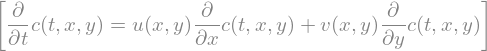

In [3]:
from sympy import Function, Derivative, Eq, symbols
from sympkf import t
x, y = symbols('x y')
c = Function('c')(t,x,y)
u = Function('u')(x,y)
v = Function('v')(x,y)
dynamics = [
    Eq(Derivative(c,t), u*Derivative(c,x)+v*Derivative(c,y)),    
]
display(dynamics)

In [4]:
from sympkf import PDESystem
dynamics = PDESystem(dynamics)

# Computation of the PKF dynamics by using SymPKF

In [5]:
from sympkf.symbolic import SymbolicPKF
pkf_advection = SymbolicPKF(dynamics)

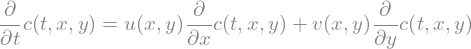

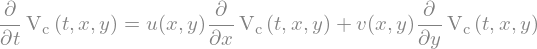

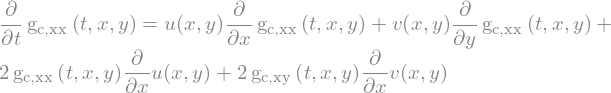

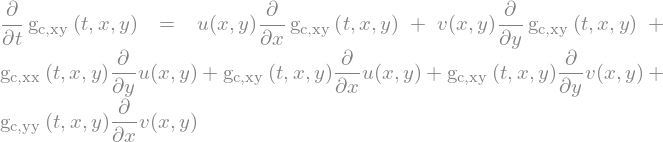

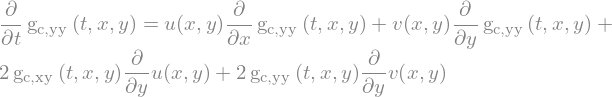

In [6]:
for equation in pkf_advection.in_metric:    display(equation)

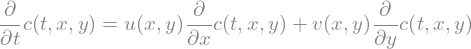

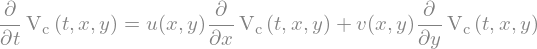

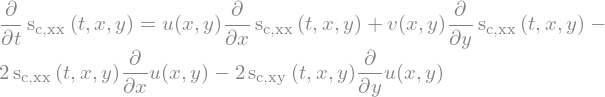

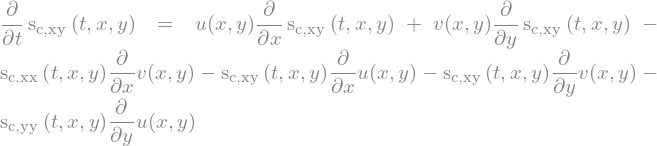

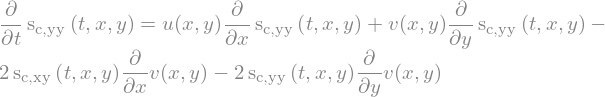

In [7]:
for equation in pkf_advection.in_aspect:    display(equation)

## Conclusion <a id='conclusion'/>

We found that the PKF dynamics for advection dynamics is the closed system given by
$$
        \left\{
        \begin{array}{l}
        \partial_t c +\mathbf{u}\nabla c = 0,\\
        \partial_t V_c +\mathbf{u}\nabla V_c = 0,\\
        \partial_t \mathbf{s}_c +\mathbf{u}\nabla\mathbf{s}_c = 
            \left(\nabla\mathbf{u}\right) \mathbf{s}_c+ \mathbf{s}_c\left(\nabla\mathbf{u}\right)^T.
        \end{array}
        \right .
$$
Which also reads as 
$$
\left\{
\begin{array}{l}
\displaystyle \frac{\partial}{\partial t} c{\left(t,x,y \right)} = - u{\left(x,y \right)} \frac{\partial}{\partial x} c{\left(t,x,y \right)} - v{\left(x,y \right)} \frac{\partial}{\partial y} c{\left(t,x,y \right)},\\
\displaystyle \frac{\partial}{\partial t} \operatorname{{V_{c}}}{\left(t,x,y \right)} = - u{\left(x,y \right)} \frac{\partial}{\partial x} \operatorname{{V_{c}}}{\left(t,x,y \right)} - v{\left(x,y \right)} \frac{\partial}{\partial y} \operatorname{{V_{c}}}{\left(t,x,y \right)},\\
\displaystyle \frac{\partial}{\partial t} \operatorname{{s_{c,xx}}}{\left(t,x,y \right)} = - u{\left(x,y \right)} \frac{\partial}{\partial x} \operatorname{{s_{c,xx}}}{\left(t,x,y \right)} - v{\left(x,y \right)} \frac{\partial}{\partial y} \operatorname{{s_{c,xx}}}{\left(t,x,y \right)} + 2 \operatorname{{s_{c,xx}}}{\left(t,x,y \right)} \frac{\partial}{\partial x} u{\left(x,y \right)} + 2 \operatorname{{s_{c,xy}}}{\left(t,x,y \right)} \frac{\partial}{\partial y} u{\left(x,y \right)}\\
\displaystyle \frac{\partial}{\partial t} \operatorname{{s_{c,xy}}}{\left(t,x,y \right)} = - u{\left(x,y \right)} \frac{\partial}{\partial x} \operatorname{{s_{c,xy}}}{\left(t,x,y \right)} - v{\left(x,y \right)} \frac{\partial}{\partial y} \operatorname{{s_{c,xy}}}{\left(t,x,y \right)} + \operatorname{{s_{c,xx}}}{\left(t,x,y \right)} \frac{\partial}{\partial x} v{\left(x,y \right)} + \operatorname{{s_{c,xy}}}{\left(t,x,y \right)} \frac{\partial}{\partial x} u{\left(x,y \right)} + \operatorname{{s_{c,xy}}}{\left(t,x,y \right)} \frac{\partial}{\partial y} v{\left(x,y \right)} + \operatorname{{s_{c,yy}}}{\left(t,x,y \right)} \frac{\partial}{\partial y} u{\left(x,y \right)},\\
\displaystyle \frac{\partial}{\partial t} \operatorname{{s_{c,yy}}}{\left(t,x,y \right)} = - u{\left(x,y \right)} \frac{\partial}{\partial x} \operatorname{{s_{c,yy}}}{\left(t,x,y \right)} - v{\left(x,y \right)} \frac{\partial}{\partial y} \operatorname{{s_{c,yy}}}{\left(t,x,y \right)} + 2 \operatorname{{s_{c,xy}}}{\left(t,x,y \right)} \frac{\partial}{\partial x} v{\left(x,y \right)} + 2 \operatorname{{s_{c,yy}}}{\left(t,x,y \right)} \frac{\partial}{\partial y} v{\left(x,y \right)}.
\end{array}
\right. 
$$   